In [1]:
import sys
import os
import pathlib
import json
import pyvista as pv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


working_dir = pathlib.Path(os.path.abspath(""))
sys.path.append(str(working_dir.parents[1]))
from runs import find_runs  # noqa: E402

In [2]:
location_error = pd.DataFrame()
velocity_error = pd.DataFrame()

# Iterate over all runs
for run_path in find_runs(working_dir.parent):
    # Read parameters.json
    with open(run_path / "parameters.json") as file:
        parameters = json.load(file)

    # Calculate mean L2 error norm for each timestep
    location_error_data = []
    velocity_error_data = []
    indices = []
    for timestep_path in (run_path / "solution").glob("*_particles_*.pvtu"):
        mesh = pv.read(timestep_path)

        # Calculate error norm for each particle
        mesh["location_error"] = np.linalg.norm(
            mesh.points - mesh["analytical_location"], axis=1
        )

        # For the velocity, we calculate the relative error
        mesh["velocity_error"] = np.linalg.norm(
            mesh["velocity"] - mesh["analytical_velocity"], axis=1
        )
        mesh["velocity_error"] /= np.linalg.norm(mesh["analytical_velocity"], axis=1)

        # Calculate mean error norm over all particles
        location_error_data.append(mesh["location_error"].mean())
        velocity_error_data.append(mesh["velocity_error"].mean())

        # Use the timestep number from the filename as index
        indices.append(int(timestep_path.stem.split("_")[-1]))

    # Generate descriptive column name
    column_name = {
        "nearest-neighbor": "NN",
        "rbf-pum-direct": "RBF",
    }[parameters["mapping"]]

    if parameters["mapping"] == "rbf-pum-direct":
        column_name += (
            "_"
            + {
                "compact-polynomial-c0": "CP0",
                "compact-polynomial-c2": "CP2",
                "compact-polynomial-c4": "CP4",
                "compact-polynomial-c6": "CP6",
                "compact-polynomial-c8": "CP8",
            }[parameters["basis_function"]]
        )

        column_name += f"_{parameters['support_radius']}"

    column_name += f"_{parameters['refinement']}"

    # Insert into DataFrame
    location_error[column_name] = pd.Series(data=location_error_data, index=indices)
    velocity_error[column_name] = pd.Series(data=velocity_error_data, index=indices)

In [3]:
# Sort columns by name
location_error.sort_index(inplace=True, axis=1)
velocity_error.sort_index(inplace=True, axis=1)

# Sort rows by timestep number
location_error.sort_index(inplace=True, axis=0)
velocity_error.sort_index(inplace=True, axis=0)

In [4]:
velocity_error.filter(like="NN", axis=1).describe()

,NN_0,NN_1,NN_2,NN_3,NN_4,NN_5,NN_6,NN_7,NN_8,NN_9
count,201.0,201.0,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000
mean,1.0,1.0,0.441635,0.234853,0.103553,0.054533,0.033201,0.023436,0.019691,0.018572
std,0.0,0.0,0.101660,0.087572,0.090752,0.095330,0.097589,0.098675,0.099111,0.099245
min,1.0,1.0,0.250885,0.143027,0.073413,0.036769,0.018976,0.010328,0.006472,0.004786
25%,1.0,1.0,0.341174,0.185407,0.087567,0.042241,0.021327,0.011152,0.007000,0.005582
50%,1.0,1.0,0.472677,0.223973,0.094334,0.044000,0.021908,0.011531,0.007628,0.006549
75%,1.0,1.0,0.511753,0.266429,0.099528,0.045841,0.022679,0.012285,0.008320,0.007430
max,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
velocity_error.filter(like="RBF_CP4", axis=1).describe()

,RBF_CP4_0.5_0,RBF_CP4_0.5_1,RBF_CP4_0.5_2,RBF_CP4_0.5_3,RBF_CP4_0.5_4,RBF_CP4_0.5_5,RBF_CP4_0.5_6,RBF_CP4_0.5_7,RBF_CP4_0.5_8,RBF_CP4_0.5_9
count,201.0,201.0,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000
mean,1.0,1.0,0.386565,0.035171,0.018336,0.018237,0.018234,0.018234,0.018234,0.018234
std,0.0,0.0,0.152228,0.097641,0.099273,0.099284,0.099285,0.099285,0.099285,0.099285
min,1.0,1.0,0.112232,0.012685,0.004673,0.004547,0.004532,0.004532,0.004532,0.004532
25%,1.0,1.0,0.254866,0.018027,0.005262,0.005162,0.005156,0.005155,0.005155,0.005155
50%,1.0,1.0,0.413787,0.024619,0.006447,0.006360,0.006355,0.006354,0.006354,0.006354
75%,1.0,1.0,0.514248,0.030751,0.007224,0.007172,0.007165,0.007164,0.007164,0.007164
max,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
velocity_error.filter(like="RBF_CP8", axis=1).describe()

,RBF_CP8_0.5_0,RBF_CP8_0.5_1,RBF_CP8_0.5_2,RBF_CP8_0.5_3,RBF_CP8_0.5_4,RBF_CP8_0.5_5,RBF_CP8_0.5_6,RBF_CP8_0.5_7,RBF_CP8_0.5_8
count,201.0,201.0,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000
mean,1.0,1.0,0.687212,0.040602,0.018326,0.018235,0.018234,0.018234,0.018234
std,0.0,0.0,0.232111,0.097210,0.099274,0.099285,0.099285,0.099285,0.099285
min,1.0,1.0,0.201844,0.015210,0.004589,0.004536,0.004532,0.004532,0.004532
25%,1.0,1.0,0.459853,0.022086,0.005258,0.005156,0.005155,0.005155,0.005155
50%,1.0,1.0,0.725741,0.030074,0.006456,0.006355,0.006354,0.006354,0.006354
75%,1.0,1.0,0.915001,0.038281,0.007242,0.007165,0.007164,0.007164,0.007164
max,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


array([<Axes: xlabel='timestep'>, <Axes: xlabel='timestep'>,
       <Axes: xlabel='timestep'>], dtype=object)

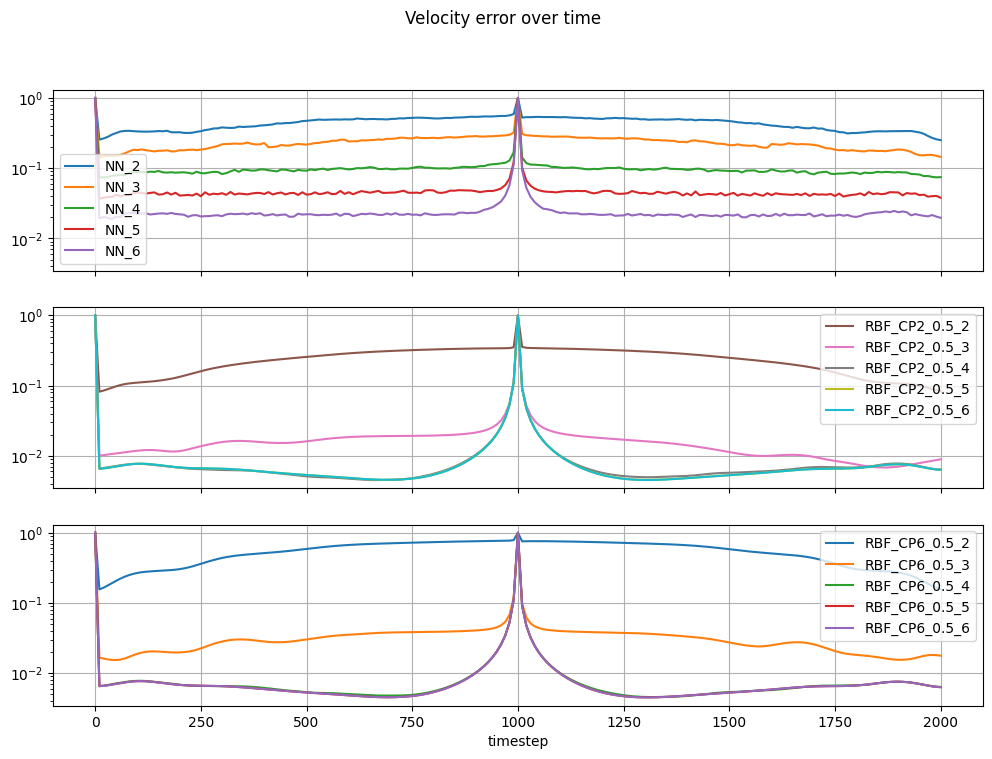

In [7]:
velocity_error.filter(
    axis=1,
    items=[
        "NN_2",
        "NN_3",
        "NN_4",
        "NN_5",
        "NN_6",
        "RBF_CP2_0.5_2",
        "RBF_CP2_0.5_3",
        "RBF_CP2_0.5_4",
        "RBF_CP2_0.5_5",
        "RBF_CP2_0.5_6",
        "RBF_CP6_0.5_2",
        "RBF_CP6_0.5_3",
        "RBF_CP6_0.5_4",
        "RBF_CP6_0.5_5",
        "RBF_CP6_0.5_6",
    ],
).plot(
    title="Velocity error over time",
    figsize=(12, 8),
    grid=True,
    xlabel="timestep",
    logy=True,
    sharey=True,
    subplots=[
        (
            "NN_2",
            "NN_3",
            "NN_4",
            "NN_5",
            "NN_6",
        ),
        (
            "RBF_CP2_0.5_2",
            "RBF_CP2_0.5_3",
            "RBF_CP2_0.5_4",
            "RBF_CP2_0.5_5",
            "RBF_CP2_0.5_6",
        ),
        (
            "RBF_CP6_0.5_2",
            "RBF_CP6_0.5_3",
            "RBF_CP6_0.5_4",
            "RBF_CP6_0.5_5",
            "RBF_CP6_0.5_6",
        ),
    ],
)

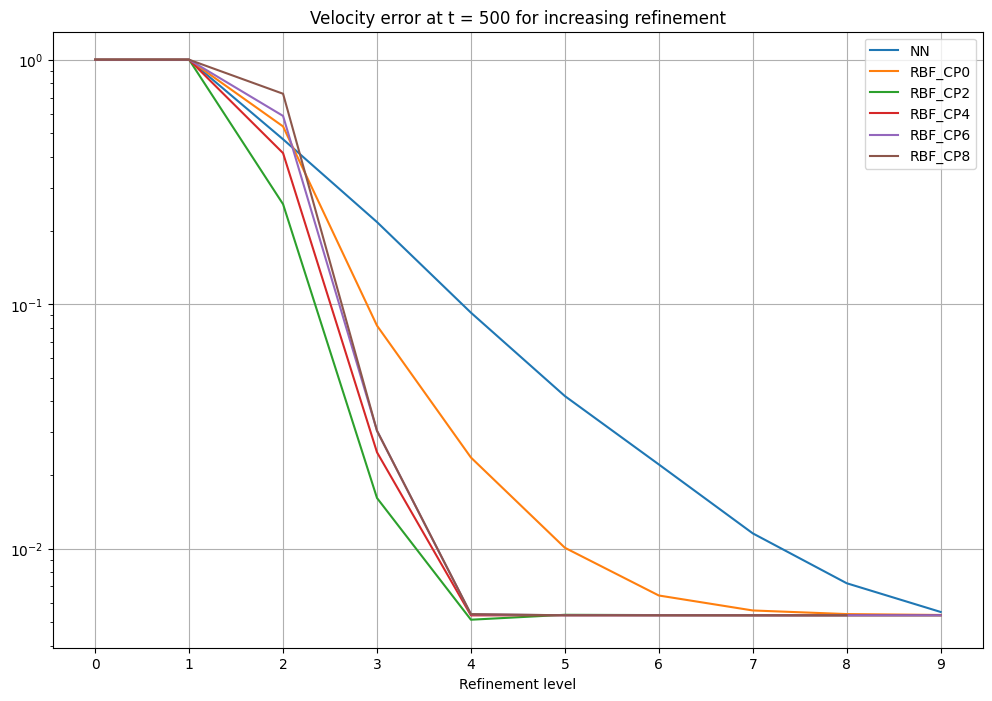

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))

t = 500
velocity_error_T = velocity_error.T.loc[:, t]

velocity_error_T.filter(axis=0, like="NN").plot(ax=ax, label="NN")
velocity_error_T.filter(axis=0, like="RBF_CP0").plot(ax=ax, label="RBF_CP0")
velocity_error_T.filter(axis=0, like="RBF_CP2").plot(ax=ax, label="RBF_CP2")
velocity_error_T.filter(axis=0, like="RBF_CP4").plot(ax=ax, label="RBF_CP4")
velocity_error_T.filter(axis=0, like="RBF_CP6").plot(ax=ax, label="RBF_CP6")
velocity_error_T.filter(axis=0, like="RBF_CP8").plot(ax=ax, label="RBF_CP8")

ax.set_title(f"Velocity error at t = {t} for increasing refinement")
ax.legend()
ax.grid()
ax.set_xlabel("Refinement level")
ax.set_xticks(range(len(velocity_error_T.filter(axis=0, like="NN").index)))
ax.set_xticklabels(range(len(velocity_error_T.filter(axis=0, like="NN").index)))
ax.set_yscale("log")